# Benchmark generation

This Jupyter notebook generates the following figures and tables in our paper, "Pulsar: Secure Steganography for Diffusion Models":

- Figure 2: Sample output from the `celebahq` model.
- Figure 3: Another sample output for the `celebahq` model.
- Figure 4: The distribution of message lengths in 100 images generated for each of the models used in $Pulsar$.
- Figure 5: The mean time spent to perform $Pulsar$ tasks for the church model on Desktop and Laptop.
- Table 1: Average execution time for offline, encoding, and decoding steps on Desktop and Laptop for all models for 100 runs.
- Table 2: Bytes encoded per-image for all models for 100 runs.

It also generates the following appendix figures and tables:

- Table 3: The library of error correcting codes used for $Pulsar$.
- Figure 6: Sample $Pulsar$ outputs for the `church` model.
- Figure 7: Sample $Pulsar$ outputs for the `celebahq` model.
- Figure 8: Sample $Pulsar$ outputs for the `bedroom` model.
- Figure 9: Sample $Pulsar$ outputs for the `car` model.
- Table 4: Averages from 100 trials of our $u$ experiment.
- Table 5: Averages from 100 trials of our $l$ experiment.

Markdown cells (such as this one) indicate where specific figures/tables are being generated. Some extra figures and tables are generated that may be of interest for those re-implementing Pulsar in a different context. Also, note that figures and are generated out of order from the paper for ease of figure generation.

To re-generate all figures and tables, go to `Run > Run All Cells` in the Jupyter menu.

## Benchmark loading and parsing

In [1]:
import glob
import operator

benchmark_results = {}
benchmark_results["cuda"] = {}
benchmark_results["mps"] = {}

for fname in glob.glob("./bench-results/*.json"):
    parts = fname.split("_")
    device = parts[-1].split(".")[0]
    name = "_".join(parts[3:-1])
    if name not in benchmark_results[device]:
        benchmark_results[device][name] = []

    benchmark_results[device][name].append({
        "fname": fname,
        "timestamp": int(parts[2])
    })


benchmark_results

{'cuda': {'n_to_gen': [{'fname': './bench-results/pulsar_benchmark_1723833013_n_to_gen_cuda.json',
    'timestamp': 1723833013}],
  'n_hist_bins': [{'fname': './bench-results/pulsar_benchmark_1723829104_n_hist_bins_cuda.json',
    'timestamp': 1723829104}],
  'ddpm': [{'fname': './bench-results/pulsar_benchmark_1723838235_ddpm_cuda.json',
    'timestamp': 1723838235}],
  'models': [{'fname': './bench-results/pulsar_benchmark_1723845939_models_cuda.json',
    'timestamp': 1723845939}]},
 'mps': {'models': [{'fname': './bench-results/pulsar_benchmark_1723872093_models_mps.json',
    'timestamp': 1723872093}]}}

In [2]:
import json
import numpy as np


def process_benchmark(benchmark, config_name):
    results = {}
    for (i, bench) in enumerate(benchmark[config_name]):
        for bname in bench:
            if bname == "fname":
                # Skip filenames
                continue

            if bname not in results:
                results[bname] = np.zeros(benchmark["params"]["n_iter"])
            
            to_add = bench[bname][-1]

            # Calculate time if necessary
            if "error" not in bname and bname not in "max_message_len":
                to_add = to_add - bench[bname][0]

            results[bname][i] = to_add

    stats = {}
    for bname in results:
        if "error" in bname:
            # Error Results
            stats[bname] = {
                "total": np.sum(results[bname]),
                "mean": np.mean(results[bname]),
            }
        else:
            # Non-error results
            # Note that we remove all zero entries when processing
            # This is because entries are zero in error cases
            non_zero_raw = results[bname][results[bname] != 0] 
            stats[bname] = {
                "min": np.min(non_zero_raw),
                "argmin": np.argmin(non_zero_raw),
                "max": np.max(non_zero_raw),
                "argmax": np.argmax(non_zero_raw),
                "mean": np.mean(non_zero_raw),
                "std": np.std(non_zero_raw)
            }
        
    return (results, stats)


def summarize_benchmarks(fname):
    with open(fname, "rb") as f:
        benchmark = json.load(f)

    summary = []

    for model in benchmark["params"]["models"]:
        for n_to_gen in benchmark["params"]["ns_to_gen"]:
            for n_hist_bins in benchmark["params"]["ns_hist_bins"]:
                config = {
                    "model": model,
                    "n_to_gen": n_to_gen,
                    "n_hist_bins": n_hist_bins,
                }
                config_name = "{}_{}_{}".format(model, n_to_gen, n_hist_bins)


                results, stats = process_benchmark(benchmark, config_name)

                summary.append({
                    "config": config,
                    "stats": stats,
                    "results": results,
                })

                if benchmark["params"]["end_to_end"]:
                    results, stats = process_benchmark(benchmark, config_name+"_receiver")
                    summary[-1]["stats"]["receiver"] = stats
                    summary[-1]["results"]["receiver"] = results

    return summary

# Test execution
# [(x["config"]["model"], x["stats"]) for x in summarize_benchmarks(benchmark_results['mps']['models'][-1]['fname'])]

In [3]:
# Summarize all benchmarks
for device in benchmark_results:
    for name in benchmark_results[device]:
        # Sort results by timestamp
        benchmark_results[device][name].sort(key=operator.itemgetter("timestamp"))
        # Get the latest benchmark
        summarized = summarize_benchmarks(benchmark_results[device][name][-1]["fname"])

        benchmark_results[device][name][-1]["summary"] = summarized

In [4]:
# Convert a Python list to a LaTeX table
# Each row is a list
# Each element is a column 
# If an element is a list, then that row has sub-columns

def mean_std_dev(mean, std_dev=None):
    return r"$\bar{x} = " + '{:.02f}'.format(mean) + r'$' +((r', $s = ' + '{:.02f}'.format(std_dev) + r'$') if std_dev is not None else "")

def _latex_row(row):
    row_str = "  "
    for (i, entry) in enumerate(row):
        row_str += entry
        row_str += r" & " if i < len(row) - 1 else r" \\"
    row_str += "\n"
    return row_str

def list2latex(header, table, label, caption="TODO", star=False, custom_header=None):
    output_str = r"\begin{table" + ("*" if star else "") + "}\n" 
    output_str += r"\centering" + "\n" 

    col_str = "|c||" + "".join(["c|" for _ in range(len(header) - 1)])
    output_str += r"\begin{tabular}{" + col_str + "}\n" + "\hline\n"

    if custom_header is None:
        output_str += _latex_row(header) + "\hline\n"
    else:
        output_str += custom_header

    for row in table:
        output_str += _latex_row(row)

    output_str += r"\hline" + "\n" + r"\end{tabular}" + "\n"
    output_str += r"\caption{" + caption + "}" + "\n"
    output_str += r"\label{" + label + "}" + "\n"
    output_str += r"\end{table" + ("*" if star else "") + "}\n" 
    return output_str

## Generated figures & tables

### Table 4: Averages from 100 trials of our $u$ experiment.

In [5]:
# n_hist_bin
n_hist_bins_expr = benchmark_results["cuda"]["n_hist_bins"][-1]["summary"]
n_hist_bins_header = ["Bins", "Estimation Time (sec)", "Message Length (bytes)"]
n_hist_bins_table = []

initial_model_mean = None
initial_model_std_dev = None

for expr in n_hist_bins_expr:

    bins = '{}'.format(expr['config']['n_hist_bins'])


    if 'initial_model_iteration' in expr['stats']:
        # We need to make sure we add the time it takes to run a model iteration to the subsequent experiments
        initial_model_mean = expr['stats']['initial_model_iteration']['mean']
        initial_model_std_dev= expr['stats']['initial_model_iteration']['std']
        offline_time = mean_std_dev(expr['stats']['estimate_regions']['mean'], expr['stats']['estimate_regions']['std'])
    else:
        offline_time = mean_std_dev(expr['stats']['estimate_regions']['mean'] + initial_model_mean,
                                     expr['stats']['estimate_regions']['std'] + initial_model_std_dev)
    
    mean = expr['stats']['max_message_len']['mean']
    std_dev = expr['stats']['max_message_len']['std']
    message_len = mean_std_dev(mean, std_dev)


    n_hist_bins_table.append([
        bins,
        offline_time,
        message_len
    ])

n_hist_bins_caption = r"The results of 100 trials of our $\ntogen$ experiment on Desktop."

print(list2latex(n_hist_bins_header, n_hist_bins_table, "tbl:expr:bins", n_hist_bins_caption))

\begin{table}
\centering
\begin{tabular}{|c||c|c|}
\hline
  Bins & Estimation Time (sec) & Message Length (bytes) \\
\hline
  25 & $\bar{x} = 6.26$, $s = 0.25$ & $\bar{x} = 488.44$, $s = 172.05$ \\
  50 & $\bar{x} = 6.43$, $s = 0.25$ & $\bar{x} = 566.70$, $s = 184.05$ \\
  100 & $\bar{x} = 6.45$, $s = 0.25$ & $\bar{x} = 610.12$, $s = 194.24$ \\
  125 & $\bar{x} = 6.47$, $s = 0.25$ & $\bar{x} = 605.43$, $s = 204.59$ \\
  150 & $\bar{x} = 6.48$, $s = 0.25$ & $\bar{x} = 623.10$, $s = 206.37$ \\
\hline
\end{tabular}
\caption{The results of 100 trials of our $\ntogen$ experiment on Desktop.}
\label{tbl:expr:bins}
\end{table}



### Table 5: Averages from 100 trials of our $l$ experiment.

In [6]:
# n_to_gen
n_to_gen_exprs = benchmark_results["cuda"]["n_to_gen"][-1]["summary"]

n_to_gen_header = ["Estimates", "Estimation Time (sec)", "Success Rate"]

n_to_gen_table = []

initial_model_mean = None
initial_model_std_dev = None

# Collect relevant data
for expr in n_to_gen_exprs:
    estimates_generated = '{}'.format(expr['config']['n_to_gen'])

    if 'initial_model_iteration' in expr['stats']:
        # We need to make sure we add the time it takes to run a model iteration to the subsequent experiments
        initial_model_mean = expr['stats']['initial_model_iteration']['mean']
        initial_model_std_dev= expr['stats']['initial_model_iteration']['std']
        offline_time = mean_std_dev(expr['stats']['estimate_regions']['mean'], expr['stats']['estimate_regions']['std'])
    else:
        offline_time = mean_std_dev(expr['stats']['estimate_regions']['mean'] + initial_model_mean,
                                     expr['stats']['estimate_regions']['std'] + initial_model_std_dev)
    error_rate = r'{}\%'.format((1 - expr['stats']['decoding_error']['mean']) * 100)
    n_to_gen_table.append([estimates_generated, offline_time, error_rate])

n_to_gen_caption = r"The results of 100 trials of our $\ntogen$ experiment on Desktop."

print(list2latex(n_to_gen_header, n_to_gen_table, "tbl:expr:estimates", n_to_gen_caption))

\begin{table}
\centering
\begin{tabular}{|c||c|c|}
\hline
  Estimates & Estimation Time (sec) & Success Rate \\
\hline
  1 & $\bar{x} = 6.15$, $s = 0.06$ & 89.0\% \\
  3 & $\bar{x} = 6.88$, $s = 0.07$ & 94.0\% \\
  5 & $\bar{x} = 7.44$, $s = 0.07$ & 89.0\% \\
  10 & $\bar{x} = 8.84$, $s = 0.07$ & 86.0\% \\
  30 & $\bar{x} = 14.48$, $s = 0.09$ & 85.0\% \\
\hline
\end{tabular}
\caption{The results of 100 trials of our $\ntogen$ experiment on Desktop.}
\label{tbl:expr:estimates}
\end{table}



### Figures 6 to 9: Sample Pulsar outputs for the `church`, `celebahq`, `bedroom`, and `cat` models (Desktop). 

ddpm-church-256
  best message length 1143.0 bytes for image 40
    bench-results/ddpm-church-256/1723845939_models_1_100_040.png


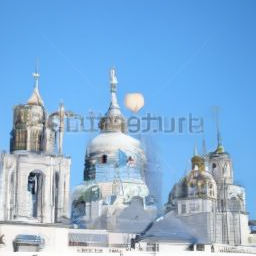

  worst message length 100.0 bytes for image 34
    bench-results/ddpm-church-256/1723845939_models_1_100_034.png


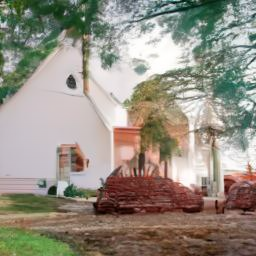

ddpm-celebahq-256
  best message length 743.0 bytes for image 89
    bench-results/ddpm-celebahq-256/1723845939_models_1_100_089.png


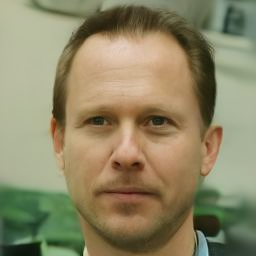

  worst message length 228.0 bytes for image 30
    bench-results/ddpm-celebahq-256/1723845939_models_1_100_030.png


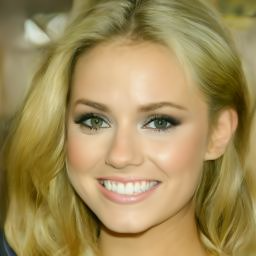

ddpm-bedroom-256
  best message length 771.0 bytes for image 4
    bench-results/ddpm-bedroom-256/1723845939_models_1_100_004.png


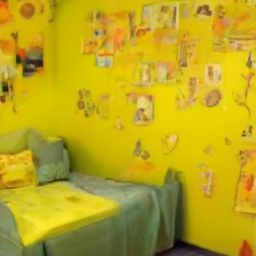

  worst message length 100.0 bytes for image 37
    bench-results/ddpm-bedroom-256/1723845939_models_1_100_037.png


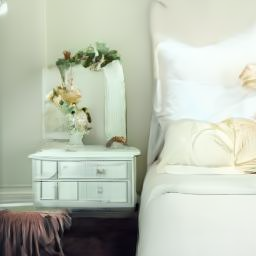

ddpm-cat-256
  best message length 1557.0 bytes for image 86
    bench-results/ddpm-cat-256/1723845939_models_1_100_086.png


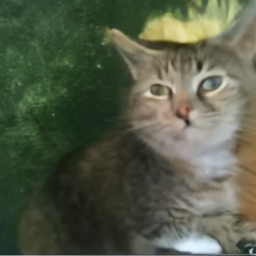

  worst message length 100.0 bytes for image 7
    bench-results/ddpm-cat-256/1723845939_models_1_100_007.png


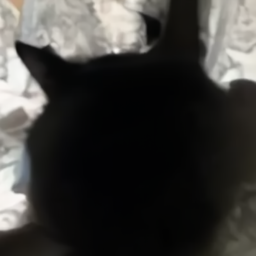

In [7]:
# cuda/models
from IPython.display import Image, display

cuda_models_exprs = benchmark_results["cuda"]["models"][-1]["summary"]
cuda_models_timestamp = benchmark_results["cuda"]["models"][-1]["timestamp"]

# cuda_models_header = ["Model name", "Sender offline time (sec)", "Sender online time (sec)", "Receiver offline time (sec)", "Receiver online time (sec)", "Success rate", "Expected throughput per image (bytes)"]
cuda_models_header = ["Model name", "Offline time (sec)", "Encoding time (sec)", "Decoding time (sec)", "Success rate", "Expected throughput (bytes)"]
cuda_models_table = []

for expr in cuda_models_exprs:
    model = expr["config"]["model"]
    n_to_gen = expr["config"]["n_to_gen"]
    n_hist_bins = expr["config"]["n_hist_bins"]
    stats = expr["stats"]

    # Get the best and worst images in terms of message length
    print(model)
    print(" ", "best message length", stats["max_message_len"]["max"], "bytes for image", stats["max_message_len"]["argmax"] )
    best_fname = "bench-results/{}/{}_models_{}_{}_{:03}.png".format(model, cuda_models_timestamp, n_to_gen, n_hist_bins, stats["max_message_len"]["argmax"])
    print("   ", best_fname)
    display(Image(best_fname))
    print(" ", "worst message length", stats["max_message_len"]["min"], "bytes for image", stats["max_message_len"]["argmin"] )
    worst_fname = "bench-results/{}/{}_models_{}_{}_{:03}.png".format(model, cuda_models_timestamp, n_to_gen, n_hist_bins, stats["max_message_len"]["argmin"])
    print("   ", worst_fname)
    display(Image(worst_fname))

    # Collect data for table
    model_name = r"\texttt{" + model + r"}"
    sender_offline_time = mean_std_dev(stats["estimate_regions"]["mean"], stats["estimate_regions"]["std"])
    sender_online_time = mean_std_dev(stats["generate_with_regions"]["mean"],stats["generate_with_regions"]["std"])
    receiver_offline_time = mean_std_dev(stats["receiver"]["estimate_regions"]["mean"], stats["receiver"]["estimate_regions"]["std"])
    receiver_online_time = mean_std_dev(stats["receiver"]["reveal_with_regions"]["mean"], stats["receiver"]["reveal_with_regions"]["std"])
    success_rate = r'{}\%'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * 100)
    expected_bytes = r'$E[X] =' + '{:.02f}'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * stats["max_message_len"]["mean"]) +r'$'

    # cuda_models_table.append([model_name, sender_offline_time, sender_online_time, receiver_offline_time, receiver_online_time, success_rate, expected_bytes])
    cuda_models_table.append([
        model_name, 
        sender_offline_time, 
        sender_online_time, 
        receiver_online_time, 
        success_rate, expected_bytes])

cuda_models_label = "tbl:cuda-models"

### Extra table: Average execution time for offline, encoding, and decoding steps on Desktop for all models for 100 runs.

In [8]:
print(list2latex(cuda_models_header, cuda_models_table, "tbl:expr:cuda", star=True))

\begin{table*}
\centering
\begin{tabular}{|c||c|c|c|c|c|}
\hline
  Model name & Offline time (sec) & Encoding time (sec) & Decoding time (sec) & Success rate & Expected throughput (bytes) \\
\hline
  \texttt{ddpm-church-256} & $\bar{x} = 6.27$, $s = 0.06$ & $\bar{x} = 1.85$, $s = 0.16$ & $\bar{x} = 4.65$, $s = 1.10$ & 90.0\% & $E[X] =544.94$ \\
  \texttt{ddpm-celebahq-256} & $\bar{x} = 6.26$, $s = 0.05$ & $\bar{x} = 1.82$, $s = 0.14$ & $\bar{x} = 4.15$, $s = 0.79$ & 94.0\% & $E[X] =423.53$ \\
  \texttt{ddpm-bedroom-256} & $\bar{x} = 6.30$, $s = 0.20$ & $\bar{x} = 1.72$, $s = 0.13$ & $\bar{x} = 3.39$, $s = 0.82$ & 92.0\% & $E[X] =299.50$ \\
  \texttt{ddpm-cat-256} & $\bar{x} = 6.25$, $s = 0.05$ & $\bar{x} = 1.76$, $s = 0.19$ & $\bar{x} = 3.84$, $s = 1.49$ & 98.0\% & $E[X] =431.18$ \\
\hline
\end{tabular}
\caption{TODO}
\label{tbl:expr:cuda}
\end{table*}



### Extra table: Comparison between the DDPM and DDIM versions of Pulsar.

In [9]:
# DDPM vs DDIM comparison

cuda_ddpm_exprs = benchmark_results["cuda"]["ddpm"][-1]["summary"]
cuda_ddpm_timestamp = benchmark_results["cuda"]["ddpm"][-1]["timestamp"]

cuda_scheduler_header = ["Scheduler", "Offline time (sec)", "Encoding time (sec)", "Decoding time (sec)", "Success rate", "Expected throughput (bytes)"]
cuda_scheduler_table = []

# Get the information from the DDPM experiments
expr = cuda_ddpm_exprs[0]
n_to_gen = expr["config"]["n_to_gen"]
n_hist_bins = expr["config"]["n_hist_bins"]
stats = expr["stats"]


# Collect the data for table
scheduler_name = r"DDPM"
sender_offline_time = mean_std_dev(stats["estimate_regions"]["mean"], stats["estimate_regions"]["std"])
sender_online_time = mean_std_dev(stats["generate_with_regions"]["mean"],stats["generate_with_regions"]["std"])
receiver_offline_time = mean_std_dev(stats["receiver"]["estimate_regions"]["mean"], stats["receiver"]["estimate_regions"]["std"])
receiver_online_time = mean_std_dev(stats["receiver"]["reveal_with_regions"]["mean"], stats["receiver"]["reveal_with_regions"]["std"])
success_rate = r'{}\%'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * 100)
expected_bytes = r'$E[X] =' + '{:.02f}'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * stats["max_message_len"]["mean"]) +r'$'

cuda_scheduler_table.append([
    scheduler_name, 
    sender_offline_time, 
    sender_online_time, 
    receiver_online_time, 
    success_rate, expected_bytes])

# Now, get the data for the DDIM experiments
for expr in cuda_models_exprs:
    model = expr["config"]["model"]

    if "church" not in model:
        continue

    n_to_gen = expr["config"]["n_to_gen"]
    n_hist_bins = expr["config"]["n_hist_bins"]
    stats = expr["stats"]

    # Collect data for table
    scheduler_name = r"DDIM"
    sender_offline_time = mean_std_dev(stats["estimate_regions"]["mean"], stats["estimate_regions"]["std"])
    sender_online_time = mean_std_dev(stats["generate_with_regions"]["mean"],stats["generate_with_regions"]["std"])
    receiver_offline_time = mean_std_dev(stats["receiver"]["estimate_regions"]["mean"], stats["receiver"]["estimate_regions"]["std"])
    receiver_online_time = mean_std_dev(stats["receiver"]["reveal_with_regions"]["mean"], stats["receiver"]["reveal_with_regions"]["std"])
    success_rate = r'{}\%'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * 100) 
    expected_bytes = r'$E[X] =' + '{:.02f}'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * stats["max_message_len"]["mean"]) +r'$'

    cuda_scheduler_table.append([
        scheduler_name, 
        sender_offline_time, 
        sender_online_time, 
        receiver_online_time, 
        success_rate, expected_bytes])
    
    # We only want the church results from the DDIM experiments
    break 



cuda_scheduler_label = "tbl:expr:ddpm"



print(list2latex(cuda_scheduler_header, cuda_scheduler_table, cuda_scheduler_label, star=True))

\begin{table*}
\centering
\begin{tabular}{|c||c|c|c|c|c|}
\hline
  Scheduler & Offline time (sec) & Encoding time (sec) & Decoding time (sec) & Success rate & Expected throughput (bytes) \\
\hline
  DDPM & $\bar{x} = 31.57$, $s = 0.16$ & $\bar{x} = 1.93$, $s = 0.16$ & $\bar{x} = 5.37$, $s = 1.08$ & 92.0\% & $E[X] =750.41$ \\
  DDIM & $\bar{x} = 6.27$, $s = 0.06$ & $\bar{x} = 1.85$, $s = 0.16$ & $\bar{x} = 4.65$, $s = 1.10$ & 90.0\% & $E[X] =544.94$ \\
\hline
\end{tabular}
\caption{TODO}
\label{tbl:expr:ddpm}
\end{table*}



### Extra: Histograms of bytes encoded for each model.

bench-results/ddpm-church-256.pdf


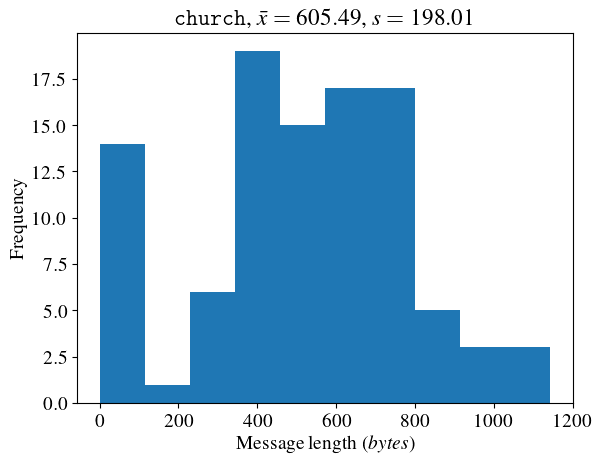

bench-results/ddpm-celebahq-256.pdf


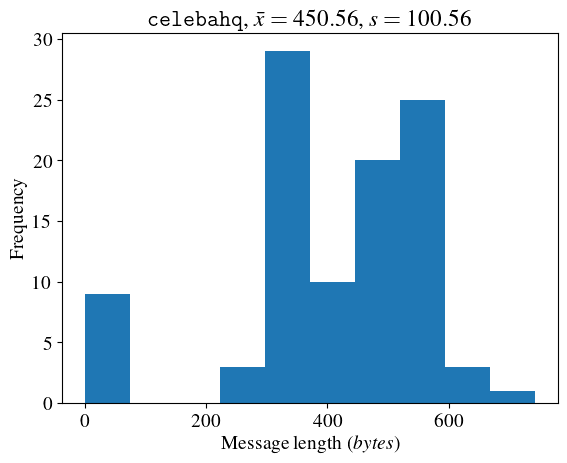

bench-results/ddpm-bedroom-256.pdf


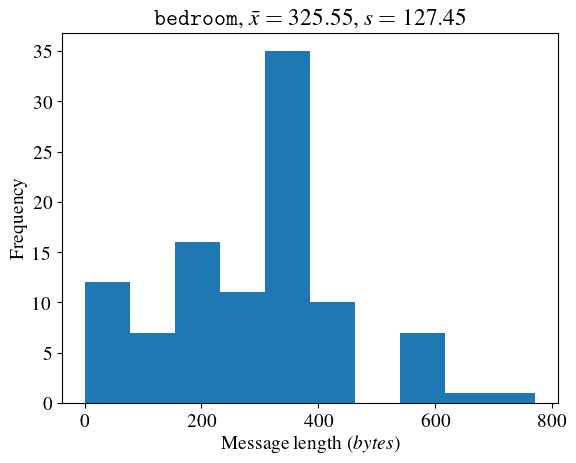

bench-results/ddpm-cat-256.pdf


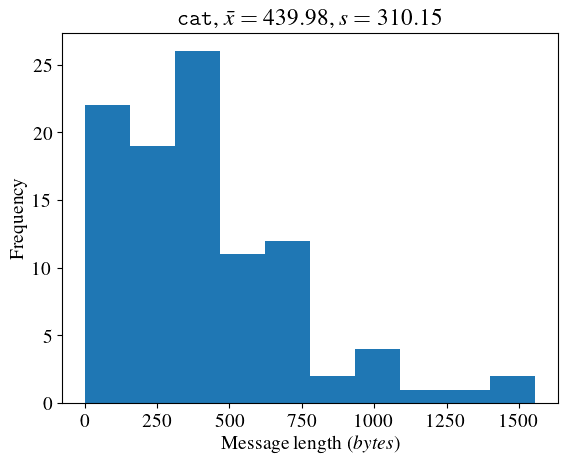

In [10]:
# histograms
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size": 14,
})

for expr in cuda_models_exprs:
    plt.hist(expr["results"]["max_message_len"])
    plt.title(r"\texttt{" + expr["config"]["model"].split("-")[1] + r"}, " + mean_std_dev(expr["stats"]["max_message_len"]["mean"], expr["stats"]["max_message_len"]["std"]))
    plt.xlabel("Message length ({\it bytes})")
    plt.ylabel("Frequency", style='italic')
    plt_fname = "bench-results/{}.pdf".format(expr["config"]["model"])
    plt.savefig(plt_fname)
    print(plt_fname)
    plt.show()



### Figure 4: The distribution of message lengths in 100 images generated for each of the models used in $Pulsar$.

bench-results/ddpm-all.pdf


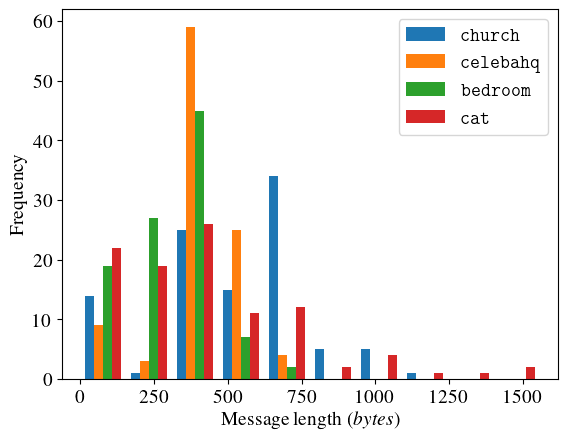

In [11]:
plt.hist([expr["results"]["max_message_len"] for expr in cuda_models_exprs], 
         label=[r"\texttt{" + expr["config"]["model"].split("-")[1] + r"}" for expr in cuda_models_exprs])
         # label=[r"\texttt{" + expr["config"]["model"].split("-")[1] + r"}, " + mean_std_dev(expr["stats"]["max_message_len"]["mean"], expr["stats"]["max_message_len"]["std"]) for expr in cuda_models_exprs])
# plt.title(r"\texttt{" + expr["config"]["model"] + r"}, " + mean_std_dev(expr["stats"]["max_message_len"]["mean"], expr["stats"]["max_message_len"]["std"]))
plt.xlabel("Message length ({\it bytes})")
plt.ylabel("Frequency", style='italic')
plt.legend()
plt_fname = "bench-results/ddpm-all.pdf"
plt.savefig(plt_fname)
print(plt_fname)
plt.show()


### Figures 6 to 9: Sample Pulsar outputs for the `church`, `celebahq`, `bedroom`, and `cat` models (Laptop). 

ddpm-church-256
  best message length 1143.0 bytes for image 10
    bench-results/ddpm-church-256/1723872093_models_1_100_010.png


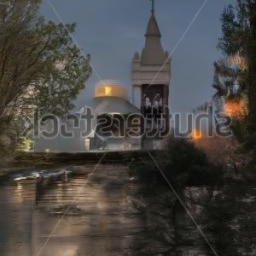

  worst message length 100.0 bytes for image 33
    bench-results/ddpm-church-256/1723872093_models_1_100_033.png


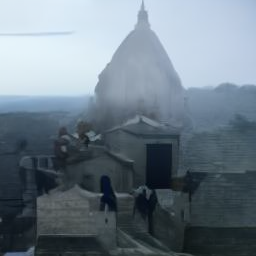

ddpm-celebahq-256
  best message length 671.0 bytes for image 65
    bench-results/ddpm-celebahq-256/1723872093_models_1_100_065.png


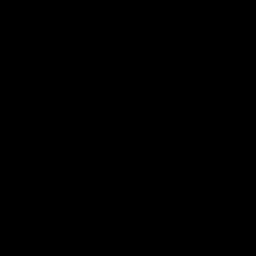

  worst message length 228.0 bytes for image 27
    bench-results/ddpm-celebahq-256/1723872093_models_1_100_027.png


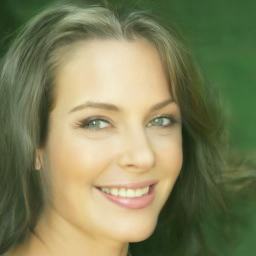

ddpm-bedroom-256
  best message length 771.0 bytes for image 3
    bench-results/ddpm-bedroom-256/1723872093_models_1_100_003.png


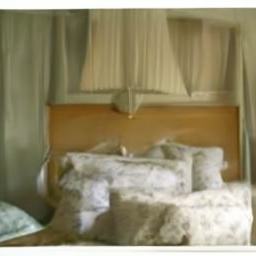

  worst message length 100.0 bytes for image 23
    bench-results/ddpm-bedroom-256/1723872093_models_1_100_023.png


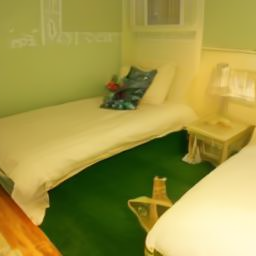

ddpm-cat-256
  best message length 1543.0 bytes for image 86
    bench-results/ddpm-cat-256/1723872093_models_1_100_086.png


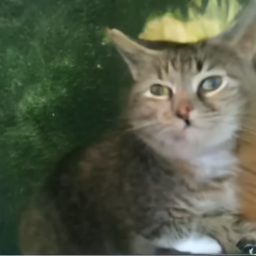

  worst message length 100.0 bytes for image 7
    bench-results/ddpm-cat-256/1723872093_models_1_100_007.png


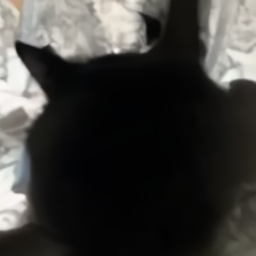

In [12]:
# mps/models
from IPython.display import Image, display

mps_models_exprs = benchmark_results["mps"]["models"][-1]["summary"]
mps_models_timestamp = benchmark_results["mps"]["models"][-1]["timestamp"]

# mps_models_header = ["Model name", "Sender offline time (sec)", "Sender online time (sec)", "Receiver offline time (sec)", "Receiver online time (sec)", "Success rate", "Expected throughput per image (bytes)"]
mps_models_header = ["Model name", "Offline time (sec)", "Encoding time (sec)", "Decoding time (sec)", "Success rate", "Expected throughput (bytes)"]
mps_models_table = []

for expr in mps_models_exprs:
    model = expr["config"]["model"]
    n_to_gen = expr["config"]["n_to_gen"]
    n_hist_bins = expr["config"]["n_hist_bins"]
    stats = expr["stats"]

    # Get the best and worst images in terms of message length
    print(model)
    print(" ", "best message length", stats["max_message_len"]["max"], "bytes for image", stats["max_message_len"]["argmax"] )
    best_fname = "bench-results/{}/{}_models_{}_{}_{:03}.png".format(model, mps_models_timestamp, n_to_gen, n_hist_bins, stats["max_message_len"]["argmax"])
    print("   ", best_fname)
    display(Image(best_fname))
    print(" ", "worst message length", stats["max_message_len"]["min"], "bytes for image", stats["max_message_len"]["argmin"] )
    worst_fname = "bench-results/{}/{}_models_{}_{}_{:03}.png".format(model, mps_models_timestamp, n_to_gen, n_hist_bins, stats["max_message_len"]["argmin"])
    print("   ", worst_fname)
    display(Image(worst_fname))

    # Collect data for table
    model_name = r"\texttt{" + model + r"}"
    sender_offline_time = mean_std_dev(stats["estimate_regions"]["mean"], stats["estimate_regions"]["std"])
    sender_online_time = mean_std_dev(stats["generate_with_regions"]["mean"],stats["generate_with_regions"]["std"])
    receiver_offline_time = mean_std_dev(stats["receiver"]["estimate_regions"]["mean"], stats["receiver"]["estimate_regions"]["std"])
    receiver_online_time = mean_std_dev(stats["receiver"]["reveal_with_regions"]["mean"], stats["receiver"]["reveal_with_regions"]["std"])
    success_rate = r'{}\%'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * 100)
    expected_bytes = r'$E[X] =' + '{:.02f}'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * stats["max_message_len"]["mean"]) +r'$'

    # mps_models_table.append([model_name, sender_offline_time, sender_online_time, receiver_offline_time, receiver_online_time, success_rate, expected_bytes])
    mps_models_table.append([
        model_name, 
        sender_offline_time, 
        sender_online_time, 
        receiver_online_time, 
        success_rate, expected_bytes])

mps_models_label = "tbl:mps-models"

### Extra table: Average execution time for offline, encoding, and decoding steps on Laptop for all models for 100 runs.

In [13]:
print(list2latex(mps_models_header, mps_models_table, "tbl:expr:mps", star=True))


\begin{table*}
\centering
\begin{tabular}{|c||c|c|c|c|c|}
\hline
  Model name & Offline time (sec) & Encoding time (sec) & Decoding time (sec) & Success rate & Expected throughput (bytes) \\
\hline
  \texttt{ddpm-church-256} & $\bar{x} = 12.33$, $s = 0.23$ & $\bar{x} = 3.06$, $s = 0.14$ & $\bar{x} = 3.75$, $s = 0.60$ & 92.0\% & $E[X] =557.53$ \\
  \texttt{ddpm-celebahq-256} & $\bar{x} = 12.30$, $s = 0.16$ & $\bar{x} = 3.08$, $s = 0.15$ & $\bar{x} = 3.54$, $s = 0.47$ & 90.0\% & $E[X] =396.66$ \\
  \texttt{ddpm-bedroom-256} & $\bar{x} = 12.32$, $s = 0.17$ & $\bar{x} = 3.07$, $s = 0.19$ & $\bar{x} = 3.22$, $s = 0.50$ & 93.0\% & $E[X] =301.92$ \\
  \texttt{ddpm-cat-256} & $\bar{x} = 12.35$, $s = 0.18$ & $\bar{x} = 3.01$, $s = 0.15$ & $\bar{x} = 3.26$, $s = 0.77$ & 98.0\% & $E[X] =417.47$ \\
\hline
\end{tabular}
\caption{TODO}
\label{tbl:expr:mps}
\end{table*}



### Table 1: Average execution time for offline, encoding, and decoding steps on Desktop and Laptop for all models for 100 runs.

In [14]:
# Create combined cuda/mps tables

combined_header = ["Model name", "Offline", "Encoding", "Decoding", "Offline", "Encoding", "Decoding"]
combined_header_custom = r"""\multirow{2}*{Model} & \multicolumn{3}{c|}{Desktop}  & \multicolumn{3}{c|}{Laptop} \\
  \cline{2-7}
   & Offline & Encoding & Decoding & Offline & Encoding & Decoding \\
\hline""" + '\n'

combined_table = []

for expr_cuda, expr_mps in zip(cuda_models_exprs, mps_models_exprs):
    model = expr_cuda["config"]["model"]
    stats_cuda = expr_cuda["stats"]
    model_name = r"\texttt{" + model.split("-")[1] + r"}"
    cuda_sender_offline_time = mean_std_dev(stats_cuda["estimate_regions"]["mean"], stats_cuda["estimate_regions"]["std"])
    cuda_sender_online_time = mean_std_dev(stats_cuda["generate_with_regions"]["mean"],stats_cuda["generate_with_regions"]["std"])
    cuda_receiver_online_time = mean_std_dev(stats_cuda["receiver"]["reveal_with_regions"]["mean"], stats_cuda["receiver"]["reveal_with_regions"]["std"])

    stats_mps = expr_mps["stats"]
    mps_sender_offline_time = mean_std_dev(stats_mps["estimate_regions"]["mean"], stats_mps["estimate_regions"]["std"])
    mps_sender_online_time = mean_std_dev(stats_mps["generate_with_regions"]["mean"],stats_mps["generate_with_regions"]["std"])
    mps_receiver_online_time = mean_std_dev(stats_mps["receiver"]["reveal_with_regions"]["mean"], stats_mps["receiver"]["reveal_with_regions"]["std"])

    combined_table.append([
        model_name,
        cuda_sender_offline_time,
        cuda_sender_online_time,
        cuda_receiver_online_time,
        mps_sender_offline_time,
        mps_sender_online_time,
        mps_receiver_online_time,
    ])

combined_caption = "Execution time for offline, encoding, and decoding steps on Desktop and Laptop for all models in our Pulsar implementation, averaged across 100 runs."

print(list2latex(combined_header, combined_table, label="tbl:expr:times", caption=combined_caption, star=True, custom_header=combined_header_custom))

\begin{table*}
\centering
\begin{tabular}{|c||c|c|c|c|c|c|}
\hline
\multirow{2}*{Model} & \multicolumn{3}{c|}{Desktop}  & \multicolumn{3}{c|}{Laptop} \\
  \cline{2-7}
   & Offline & Encoding & Decoding & Offline & Encoding & Decoding \\
\hline
  \texttt{church} & $\bar{x} = 6.27$, $s = 0.06$ & $\bar{x} = 1.85$, $s = 0.16$ & $\bar{x} = 4.65$, $s = 1.10$ & $\bar{x} = 12.33$, $s = 0.23$ & $\bar{x} = 3.06$, $s = 0.14$ & $\bar{x} = 3.75$, $s = 0.60$ \\
  \texttt{celebahq} & $\bar{x} = 6.26$, $s = 0.05$ & $\bar{x} = 1.82$, $s = 0.14$ & $\bar{x} = 4.15$, $s = 0.79$ & $\bar{x} = 12.30$, $s = 0.16$ & $\bar{x} = 3.08$, $s = 0.15$ & $\bar{x} = 3.54$, $s = 0.47$ \\
  \texttt{bedroom} & $\bar{x} = 6.30$, $s = 0.20$ & $\bar{x} = 1.72$, $s = 0.13$ & $\bar{x} = 3.39$, $s = 0.82$ & $\bar{x} = 12.32$, $s = 0.17$ & $\bar{x} = 3.07$, $s = 0.19$ & $\bar{x} = 3.22$, $s = 0.50$ \\
  \texttt{cat} & $\bar{x} = 6.25$, $s = 0.05$ & $\bar{x} = 1.76$, $s = 0.19$ & $\bar{x} = 3.84$, $s = 1.49$ & $\bar{x} = 12.35$, 

### Table 2: Bytes encoded per-image for all models for 100 runs.

In [15]:
bytes_header = ["Model", r"$\bar{x}$", r"$s$", r"Rate", "Throughput"]
bytes_table = []

for expr in cuda_models_exprs:
    model = expr["config"]["model"]
    model_name = r"\texttt{" + model.split("-")[1] + r"}"
    bar_x = "{:.02f}".format(expr["stats"]["max_message_len"]["mean"])
    s = "{:.02f}".format(expr["stats"]["max_message_len"]["std"])
    success_rate = r'{}\%'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * 100)
    expected_bytes = r'$E[X] =' + '{:.02f}'.format((1 - expr['stats']['receiver']['decoding_error']['mean']) * expr["stats"]["max_message_len"]["mean"]) +r'$'

    bytes_table.append([
        model_name,
        bar_x,
        s,
        success_rate,
        expected_bytes
    ])

bytes_caption = "Statistics about the number of bytes encoded per image for each model."
print(list2latex(bytes_header, bytes_table, label="tbl:expr:bytes", caption=bytes_caption))

\begin{table}
\centering
\begin{tabular}{|c||c|c|c|c|}
\hline
  Model & $\bar{x}$ & $s$ & Rate & Throughput \\
\hline
  \texttt{church} & 605.49 & 198.01 & 90.0\% & $E[X] =544.94$ \\
  \texttt{celebahq} & 450.56 & 100.56 & 94.0\% & $E[X] =423.53$ \\
  \texttt{bedroom} & 325.55 & 127.45 & 92.0\% & $E[X] =299.50$ \\
  \texttt{cat} & 439.98 & 310.15 & 98.0\% & $E[X] =431.18$ \\
\hline
\end{tabular}
\caption{Statistics about the number of bytes encoded per image for each model.}
\label{tbl:expr:bytes}
\end{table}



### Figure 5: The mean time spent to perform $Pulsar$ tasks for the church model on Desktop and Laptop.

bench-results/time-compare.pdf


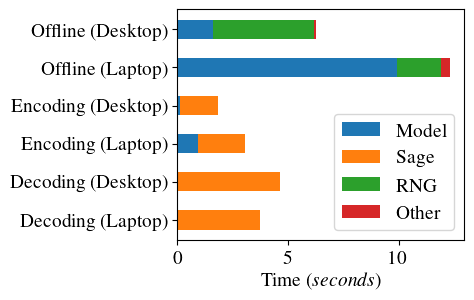

In [16]:
cuda_models_exprs = benchmark_results["cuda"]["models"][-1]["summary"]
mps_models_exprs = benchmark_results["mps"]["models"][-1]["summary"]

names = [
    "Offline (Desktop)",
    "Offline (Laptop)",
    "Encoding (Desktop)",
    "Encoding (Laptop)",
    "Decoding (Desktop)",
    "Decoding (Laptop)",
]

bars =  {
    "Model": np.zeros(6),
    "Sage": np.zeros(6),
    "RNG": np.zeros(6),
    "Other": np.zeros(6),
}

for expr_cuda in cuda_models_exprs:
    if expr_cuda['config']['model'] == 'ddpm-church-256':
        # Offline time
        total_offline = expr_cuda['stats']['estimate_regions']['mean']
        rng_offline = expr_cuda['stats']['gen_variance_noise']['mean'] + expr_cuda['stats']['gen_variance_noise_1']['mean']
        # Variance noise generation shouldn't get conflated with model time
        model_offline = expr_cuda['stats']['model_iterations']['mean'] - rng_offline
        other_offline = total_offline - (model_offline + rng_offline)
        bars["Model"][0] = model_offline
        bars["RNG"][0] = rng_offline
        bars["Other"][0] = other_offline

        # Encoding time 
        total_encoding = expr_cuda['stats']['generate_with_regions']['mean']
        model_encoding = expr_cuda['stats']['model_embed']['mean']
        sage_encoding = expr_cuda['stats']['sage_encode']['mean']
        other_encoding = total_encoding - model_encoding - sage_encoding
        bars["Model"][2] = model_encoding
        bars["Sage"][2] = sage_encoding
        bars["Other"][2] = other_encoding

        # Decoding time 
        total_decoding = expr_cuda['stats']["receiver"]['reveal_with_regions']['mean']
        model_decoding = expr_cuda['stats']["receiver"]['model_de_embed']['mean']
        sage_decoding = expr_cuda['stats']["receiver"]['sage_decode']['mean']
        other_decoding = total_decoding - model_decoding - sage_decoding
        bars["Model"][4] = model_decoding
        bars["Sage"][4] = sage_decoding
        bars["Other"][4] = other_decoding

        break

for expr_mps in mps_models_exprs:
    if expr_mps['config']['model'] == 'ddpm-church-256':
        # Offline time
        total_offline = expr_mps['stats']['estimate_regions']['mean']
        rng_offline = expr_mps['stats']['gen_variance_noise']['mean'] + expr_mps['stats']['gen_variance_noise_1']['mean']
        # Variance noise generation shouldn't get conflated with model time
        model_offline = expr_mps['stats']['model_iterations']['mean'] - rng_offline
        other_offline = total_offline - (model_offline + rng_offline)
        bars["Model"][1] = model_offline
        bars["RNG"][1] = rng_offline
        bars["Other"][1] = other_offline

        # Encoding time 
        total_encoding = expr_mps['stats']['generate_with_regions']['mean']
        model_encoding = expr_mps['stats']['model_embed']['mean']
        sage_encoding = expr_mps['stats']['sage_encode']['mean']
        other_encoding = total_encoding - model_encoding - sage_encoding
        bars["Model"][3] = model_encoding
        bars["Sage"][3] = sage_encoding
        bars["Other"][3] = other_encoding

        # Decoding time 
        total_decoding = expr_mps['stats']["receiver"]['reveal_with_regions']['mean']
        model_decoding = expr_mps['stats']["receiver"]['model_de_embed']['mean']
        sage_decoding = expr_mps['stats']["receiver"]['sage_decode']['mean']
        other_decoding = total_decoding - model_decoding - sage_decoding
        bars["Model"][5] = model_decoding
        bars["Sage"][5] = sage_decoding
        bars["Other"][5] = other_decoding

        break

width = 0.5

fig, ax = plt.subplots(figsize=(5,3))
left = np.zeros(6)

for overhead, count in bars.items():
    p = ax.barh(names, count, width, label=overhead, left=left)
    left += count

ax.legend(loc="lower right")

# the y axis increases upwards, as in a usual plot
# need to reverse the y axis to get it in the order we want
plt.gca().invert_yaxis()

# make sure everything fits in the figure
plt.tight_layout()

plt.xlabel("Time ({\it seconds})")
plt_fname = "bench-results/{}.pdf".format("time-compare")
plt.savefig(plt_fname)
print(plt_fname)
plt.show()


### Figures 2 and 3: Sample output from the `celebahq` model, with associated heatmaps.

100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


seed b'43' message len 571


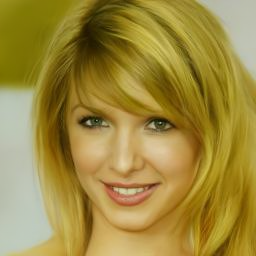

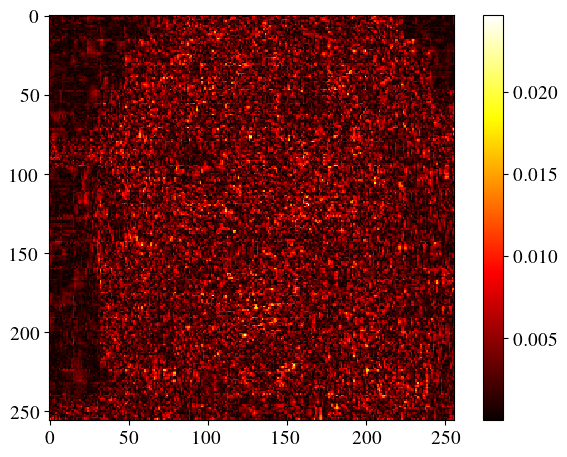

100%|██████████| 50/50 [00:00<00:00, 57.53it/s] 


error rate: tensor(0.2920, device='mps:0')


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


seed b'15' message len 257


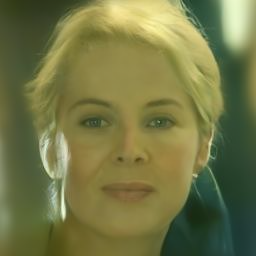

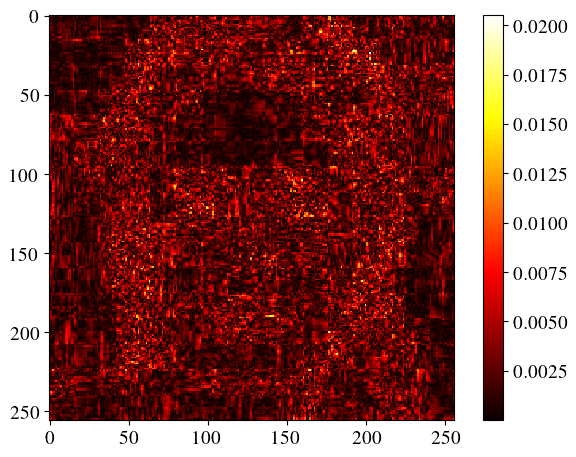

100%|██████████| 50/50 [00:00<00:00, 57.04it/s] 

error rate: tensor(0.3452, device='mps:0')


In [17]:
# heatmaps

import pulsar
from typing import *
import PIL
import torch

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

def display_sample(sample, fname=None):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])

    if fname is not None:
        image_pil.save(fname, "PNG")

    display(image_pil)

def show_heatmap(c: torch.Tensor, v: Union[Tuple[int, int], None] = None, fname="heatmap.pdf"):
    im = plt.imshow(c, cmap="hot", interpolation="nearest") if v is None else plt.imshow(
        c, cmap="hot", vmin=v[0], vmax=v[1])
    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

seeds = [b'43', b'15']
model = "ddpm-celebahq-256"

for seed in seeds:
    stego = pulsar.Pulsar(seed=seed, repo="google/" + model)
    m_len = stego.estimate_regions()
    print("seed", seed, "message len", m_len)

    display_sample(stego.all0_sample.reshape((1,3,256,256)))
    show_heatmap(abs(stego.all1_sample[0].cpu() - stego.all0_sample[0].cpu()), fname="bench-results/heatmap_{}.pdf".format(seed.decode('utf-8')))

    # get error rates
    random_message = np.packbits(
        stego.prg.get_bits(256 * 256)).tobytes()

    generate_results = stego.generate(
        random_message,
        regenerate=True,
        use_ecc=False,
    )

    last = stego.scheduler.num_inference_steps - 1
    hidden_sample = generate_results["samples"][last]["hidden"]
    all0_sample = generate_results["samples"][last]["all0"]
    all1_sample = generate_results["samples"][last]["all1"]
    encoded_message = generate_results["encoded_message"]

    reveal_results = stego.reveal(
        hidden_sample,
        all0_sample,
        all1_sample,
        encoded_message=encoded_message,
        use_ecc=False,
    )

    errors_matrix = reveal_results["pulsar"]["errors"]
    print("error rate:", errors_matrix.sum() / (256*256))


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


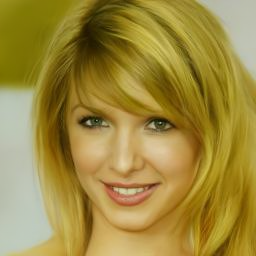

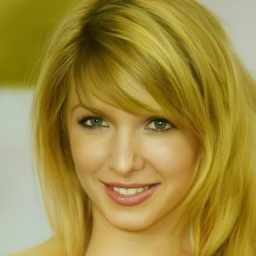

In [18]:
# generate an img0 and img1 for seed b'43' 
stego = pulsar.Pulsar(seed=b'43', repo="google/ddpm-celebahq-256")
random_message = np.packbits(
    stego.prg.get_bits(256 * 256)).tobytes()

stego.estimate_regions()

display_sample(stego.all0_sample.reshape((1,3,256,256)))
stego.save_sample(stego.all0_sample.reshape((1,3,256,256)), "bench-results/img0.png")

display_sample(stego.all1_sample.reshape((1,3,256,256)))
stego.save_sample(stego.all1_sample.reshape((1,3,256,256)), "bench-results/img1.png")


### Table 3: The library of error correcting codes used for $Pulsar$.

In [19]:
# code library

from coding import SageCode
import json

code_header = ["Error Rate", "Outer Code", "Inner Code", r"Input Size ({\it bytes})", r"Output Size ({\it bits})"]
code_table = []
codes = SageCode.CODE_LIBRARY

for er in reversed(codes):
    code_row = ["{:.02f}".format(er)]

    c = codes[er][0]

    if "from_str" in c:
        params = json.loads(c["from_str"])
        code_row.append(r"\texttt{" + r"BCHCode(GF(2), {}, {})".format(params[-3], params[-1]))
    else:
        o = c["outer"]
        i = c["inner"]
        
        # Code parameters
        if o["type"] == "ReedSolomon":
            code_row.append(r"\texttt{" + r"GeneralizedReedSolomonCode(GF({})[:{}], {})".format(o["parameters"][2], o["parameters"][0], o["parameters"][1]) + r"}")

        if i["type"] == "ReedMuller":
            code_row.append(r"\texttt{" + r"BinaryReedMullerCode({}, {})".format(i["parameters"][0], i["parameters"][1]) + r"}")
        if i["type"] == "Hamming":
            code_row.append(r"\texttt{" + r"HammingCode(GF(2), {})".format(i["parameters"][0]) + r"}")


    code_row.extend(["{}".format(c["input_size"]), "{}".format(c["output_size"])])
    code_table.append(code_row)

code_caption = r"The library of error correcting codes used for \pulsar"
print(list2latex(code_header, code_table, "tbl:ecc-library", code_caption, star=True))


\begin{table*}
\centering
\begin{tabular}{|c||c|c|c|c|}
\hline
  Error Rate & Outer Code & Inner Code & Input Size ({\it bytes}) & Output Size ({\it bits}) \\
\hline
  0.05 & \texttt{GeneralizedReedSolomonCode(GF(256)[:255], 200)} & \texttt{HammingCode(GF(2), 3)} & 200 & 3570 \\
  0.10 & \texttt{GeneralizedReedSolomonCode(GF(256)[:255], 100)} & \texttt{HammingCode(GF(2), 3)} & 100 & 3570 \\
  0.15 & \texttt{BCHCode(GF(2), 51, 17) & 243 & 9843 \\
  0.20 & \texttt{BCHCode(GF(2), 51, 17) & 257 & 14739 \\
  0.25 & \texttt{BCHCode(GF(2), 73, 18) & 228 & 19783 \\
  0.30 & \texttt{GeneralizedReedSolomonCode(GF(256)[:255], 200)} & \texttt{BinaryReedMullerCode(1, 7)} & 200 & 32640 \\
  0.35 & \texttt{GeneralizedReedSolomonCode(GF(256)[:255], 100)} & \texttt{BinaryReedMullerCode(1, 7)} & 100 & 32640 \\
\hline
\end{tabular}
\caption{The library of error correcting codes used for \pulsar}
\label{tbl:ecc-library}
\end{table*}

